# Pulsar Stars-Logistic Regression, SVM & K Nearest Neighbors
## Javier Urrecha, Raúl González y Mario Aviles
### 21 de noviembre, 2019

## 1. Importando librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


## 2. Definiendo funciones

### Producto punto
$$θ=w^TX$$

In [2]:
def theta(w, x):
    
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            theta: [np_array] a vector of the inner product of w and x with dimensions (1xm)
    """
        
    return w.T.dot(x)

### Hipótesis regresión logística
$$h_w(x)=g(w^TX)=\frac{1}{1+e^{-w^TX}}$$

In [3]:
def sigmoid(z):
    
    """
        params:
            z: [np_array] a vector of the inner product of w and x with dimensions (1xm)
        returns:
            sigmoid: [np_array] a vector of the estimations performed by the model
    """
    
    return (1/(1+np.exp(-z)))

### Función de costo regresión logística
$$J(w)=-\sum_{i=1}^{m}y^{(i)}\log h_w(x^{(i)}) +(1-y^{(i)})\log(1-h_w(x^{(i)}))$$

In [4]:
def J(w, x, y):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of target variables with dimensions (mx1), 
                where m represents the number of target variables
        returns:
            J: [double] the loss function
    """
    
    z=theta(w,x)
    h=sigmoid(z)
    return (1/(x.shape[1]))*np.sum((-y * np.log(h) - (1 - y) * np.log(1 - h)))

### Gradiente de la función de costo regresión logística
$$\frac{\delta }{\delta w_j}J(w)=(y-h_w(x))x_j$$

In [5]:
def dJ(w, x, y):
    
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of target variables with dimensions (mx1), 
                where m represents the number of target variables
        returns:
            dJ: [double] the derivative of the loss function
    """

    z=theta(w,x)
    e = sigmoid(z).T - y
    
    return (1 / (x.shape[1]))*(np.dot(x, e))

### Descenso por gradiente-LMS
$$w:= w-\alpha \nabla_wJ(w)$$

In [6]:
def optimizar_LMS(x_train, y_train, x_test, y_test, num_iter, alpha, w=None):

    """
        We calculate gradient descent for minimizing the MSE to obtain the best linear hypothesis.
            params:
                x_train: [np_array] a matrix of feature variables with dimensions (nxm), 
                    where n represents the number of feature variables and m the number of training examples
                x_test: [np_array] a matrix of feature variables with dimensions (nxm), 
                    where n represents the number of feature variables and m the number of validating examples
                y_train: [np_array] a vector of target variables with dimensions (mx1), 
                    where m represents the number of training target variables
                y_test: [np_array] a vector of target variables with dimensions (mx1), 
                    where m represents the number of validating target variables
                num_iter: [int] an integer indicating the number of iterations of the Gradient Descent algorithm
                alpha: [double] learning rate constant specifying the magnitude update step
                w: [np_array] vector that contains the initial weights to start optimzing the model with dimensions (n x 1)

            return:
                J_train: [np_array] a vector (num_iter x 1) containing all cost function evaluations during training
                J_test: [np_array] a vector (num_iter x 1) containing all cost function evaluations during training
                w: [np_array] a vector of the final optimized weights with dimensions (nx1)
    """

    if w is None:
        # Inicializamos los pesos aleatoriamente
        w = np.random.randn(x_train.shape[0], 1)

    # se generan los vectores
    it = np.arange(0, num_iter)
    J_train = np.zeros(num_iter)
    J_test = np.zeros(num_iter)

    # Se optimiza el modelo por el numero de iteraciones
    for i in range(num_iter):

        # Actualizamos los pesos
        w = w - alpha * dJ(w, x_train, y_train)

        # Guardamos los costo
        J_train[i] = J(w, x_train, y_train)

        J_test[i] = J(w, x_test, y_test)

    return w, J_train, J_test

### Función de probabilidad

In [7]:
def proba(w,x):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            probability: [np_array] a vector with the probabilities of belonging to class 1, with dimensions (1xm)
    """
    proba=np.zeros(x.shape[1])
    n=0
    for i in range(0,x.shape[1]):
        y_hat = sigmoid(theta(w, x[:,i]))
        proba[n]=y_hat
        n+=1

    return proba

### Función de clasificación

In [8]:
def classify(w,x_test,porcentaje):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            prediction: [np_array] a vector with the predicted classes, with dimensions (1xm)
    """
    prediction = []
    for i in range(0,x_test.shape[1]):
        y_hat = sigmoid(theta(w, x_test[:,i]))           
        if y_hat>porcentaje:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

### Función de normalización

In [9]:
def norm(arr,min,max):
    
    """
        params:
            arr: [np_array] a vector of training/validating examples with dimensions (mx1), 
            where m represents the number training or validating examples
            min: [double] the minimum value of the array
            max: [double] the maximum value of the array  
        returns:
            normalization: [np_array] the normalized vector (mx1)
    """
    return (arr - min) / (max - min)
    

## 3. Importando datos, balanceando y normalizando

In [10]:
# Indicamos la dirección y nombre del archivo y se imprime la cabecera
data = pd.read_csv('HTRU_2.csv')
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [11]:
#Se imprimen las dimensiones del conjunto de datos
print(data.shape)

(17898, 9)


In [12]:
#Se utiliza la función train_test_split para separar los datos en 70% de entrenamiento y 30% de validación
data_train , data_test = train_test_split(data,test_size = .3,random_state = 100)


print(data_train.shape)
print(data_test.shape)

(12528, 9)
(5370, 9)


In [13]:
#Se seleccionan las primeras ocho columnas para las características y la última columna para la clase,
#tanto en entrenamiento como en validación
X_train = data_train[[x for x in data_train.columns if x not in ["target_class"]]]
Y_train = data_train[["target_class"]]
X_test  = data_test[[x for x in data_test.columns if x not in ["target_class"]]]
Y_test  = data_test[["target_class"]]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12528, 8)
(12528, 1)
(5370, 8)
(5370, 1)


Class 0: 11385
Class 1: 1143
Proportion: 9.96 : 1


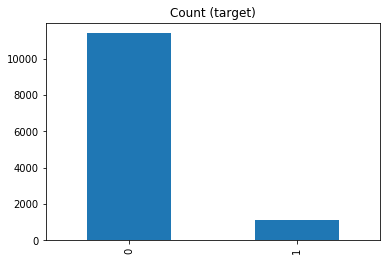

In [14]:
#Se cuentan los datos de la clase para ver si el conjunto de entrenamiento de la clase está balanceado
target_count = Y_train.target_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)');

In [15]:
#Se convierten los conjuntos de entrenamiento en vectores
X_train_list = X_train.values.tolist()
X_train = np.array(X_train_list, dtype='float64')
print(X_train.shape)
print(type(X_train))

Y_train_list = Y_train.values.tolist()
Y_train = np.array(Y_train_list, dtype='float64')
print(Y_train.shape)
print(type(Y_train))

(12528, 8)
<class 'numpy.ndarray'>
(12528, 1)
<class 'numpy.ndarray'>


In [16]:
#Se utiliza la función SMOTEEEN para balancear los datos de entrenamiento
smote_enn = SMOTEENN(random_state=0)
X_train_res, Y_train_res = smote_enn.fit_resample(X_train, Y_train)

C:\Users\73830\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: 10014
Class 1: 10835
Proportion: 0.92 : 1


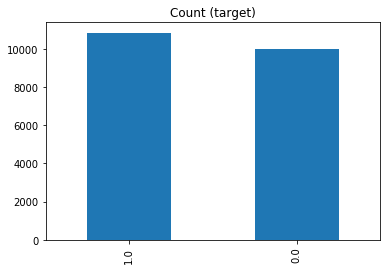

In [17]:
#Se verifica que los datos de entrenamiento estén balanceados
Y_train_res=pd.DataFrame(Y_train_res, columns=['target_class'])
target_count_res = Y_train_res.target_class.value_counts()
print('Class 0:', target_count_res[0])
print('Class 1:', target_count_res[1])
print('Proportion:', round(target_count_res[0] / target_count_res[1], 2), ': 1')

target_count_res.plot(kind='bar', title='Count (target)');

In [18]:
#Se imprime el tipo y dimensiones de los conjuntos
print(Y_train_res.shape)
print(X_train_res.shape)
print(type(Y_train_res))
print(type(X_train_res))

(20849, 1)
(20849, 8)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [19]:
#Se convierten los conjuntos en vectores
Y_train_list = Y_train_res.values.tolist()

y_train = np.array(Y_train_list, dtype='float64')

x_train=X_train_res

print(x_train.shape)
print(y_train.shape)
print(type(y_train))

(20849, 8)
(20849, 1)
<class 'numpy.ndarray'>


In [20]:
#Se convierten los conjuntos de validación en vectores
X_test_list = X_test.values.tolist()
X_test = np.array(X_test_list, dtype='float64')
x_test=X_test
print(x_test.shape)
print(type(x_test))


Y_test_list = Y_test.values.tolist()
Y_test = np.array(Y_test_list, dtype='float64')
y_test=Y_test
print(y_test.shape)
print(type(y_test))

(5370, 8)
<class 'numpy.ndarray'>
(5370, 1)
<class 'numpy.ndarray'>


In [21]:
#Se normalizan los conjuntos de datos de características
x_train_norm = np.zeros((x_train.shape[0],x_train.shape[1]))
x_test_norm = np.zeros((x_test.shape[0],x_test.shape[1]))

for i in range (0,x_train.shape[1]):
    x_train_norm[:,i]=norm(x_train[:,i],min(x_train[:,i]), max(x_train[:,i]))
    
for i in range (0,x_test.shape[1]):
    x_test_norm[:,i]=norm(x_test[:,i],min(x_train[:,i]), max(x_train[:,i]))

In [22]:
print(x_train_norm)
print(x_test_norm)

[[0.58307892 0.28067169 0.21173358 ... 0.59931604 0.15051058 0.00538666]
 [0.55426373 0.19049382 0.20553339 ... 0.0490563  0.40856306 0.16046392]
 [0.5369077  0.23974651 0.24268133 ... 0.0944188  0.32870794 0.08365848]
 ...
 [0.30431934 0.22046213 0.4154943  ... 0.33760671 0.19023258 0.01509734]
 [0.08556533 0.20065443 0.64736297 ... 0.65557516 0.08399583 0.00078449]
 [0.51801376 0.30679789 0.24278695 ... 0.65794871 0.11994746 0.00189978]]
[[0.58123876 0.14939957 0.23421148 ... 0.05359629 0.37712398 0.14024695]
 [0.53448204 0.29425281 0.22322145 ... 0.14229973 0.28370677 0.05190835]
 [0.58370624 0.43302787 0.19818329 ... 0.52204571 0.0497964  0.00147159]
 ...
 [0.37560119 0.25727772 0.27537442 ... 0.15452032 0.28973011 0.05426537]
 [0.50198653 0.29075309 0.25006323 ... 0.34093246 0.18562476 0.0132561 ]
 [0.4934549  0.2494336  0.22766679 ... 0.0555486  0.42695732 0.1622515 ]]


## 4. Creando los algoritmos

## Regresión Logística

In [23]:
#Se añade la unidad de sesgo
x_train_norm_b = np.insert(x_train_norm, 0, 1, axis=1)
x_train_norm_b = x_train_norm_b.T

print(x_train_norm_b.shape)

x_test_norm_b = np.insert(x_test_norm, 0, 1, axis=1)
x_test_norm_b = x_test_norm_b.T
print(x_test_norm_b.shape)

(9, 20849)
(9, 5370)


In [24]:
# Se asigna un vector w arbitrario
w0=1
w1 = -0.1
w2 = -0.1
w3 = 3
w4 = -0.3
w5 = -0.03
w6 = 0.03
w7 = -0.03
w8 = -0.0001

w = np.array([w0,w1, w2, w3, w4, w5, w6, w7, w8], dtype='float64')
w = w.reshape((w.shape[0], 1))
print(w.shape)
print(w)

(9, 1)
[[ 1.e+00]
 [-1.e-01]
 [-1.e-01]
 [ 3.e+00]
 [-3.e-01]
 [-3.e-02]
 [ 3.e-02]
 [-3.e-02]
 [-1.e-04]]


In [ ]:
#Se corre el descenso por gradiente para encontrar los mejores pesos w y el costo de entrenamiento y validación
alpha=0.001
num_iter=50
w, j_train, j_test = optimizar_LMS(x_train_norm_b, y_train, x_test_norm_b, y_test, num_iter, alpha, w)

print(w)

In [ ]:
#Graficamos el costo
it = np.linspace(0, num_iter, num_iter)
plt.figure()
plt.plot(it, j_train, "k", linewidth=3, label="Costo entrenamiento")
plt.plot(it, j_test, "r", linewidth=3, label="Costo validacion")
plt.title("Costo J(w)")
plt.xlabel('Iteraciones')
plt.ylabel('Costo') 
plt.legend()
plt.show()


In [ ]:
#Ejemplo con umbral de 0.85
porcentaje=0.85
#Se calculan las predicciones de clases
val_preds=classify(w,x_test_norm_b,porcentaje)
print(type(val_preds))

In [ ]:
#Las predicciones se convierten en vectores
val_preds = np.array(val_preds, dtype='float64')
val_preds = val_preds.reshape(val_preds.shape[0], 1)
print(val_preds.shape)
for i in val_preds:
    print(i)
    

In [ ]:
#Se calcula la matriz de confusión
confusion = confusion_matrix(y_test, val_preds)
print(confusion)

In [ ]:
#Se calculan las métricas de evaluación
accuracy=((confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1]))
precision=(confusion[1,1]/(confusion[1,1]+confusion[0,1]))
sensitivity=(confusion[1,1]/(confusion[1,1]+confusion[1,0]))
specificity=(confusion[0,0]/(confusion[0,0]+confusion[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

In [ ]:
#Se corre el algorítmo con diferentes umbrales
min_umbral=0.8
max_umbral=0.95
umbrals=101
umbral = np.linspace(min_umbral, max_umbral, umbrals)
logistic_accuracy=np.zeros(umbral.size-1)
logistic_precision=np.zeros(umbral.size-1)
logistic_sensitivity=np.zeros(umbral.size-1)
logistic_specificity=np.zeros(umbral.size-1)
logistic_f1score=np.zeros(umbral.size-1)
n=0

for i in range(1,101):
    porcentaje=umbral[i]
    val_preds=classify(w,x_test_norm_b,porcentaje)
    confusion_logistic = confusion_matrix(y_test, val_preds)
    
    
    logistic_accuracy[n]=((confusion_logistic[0,0]+confusion_logistic[1,1])/(confusion_logistic[0,0]+confusion_logistic[0,1]+confusion_logistic[1,0]+confusion_logistic[1,1]))
    logistic_precision[n]=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[0,1]))
    logistic_sensitivity[n]=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[1,0]))
    logistic_specificity[n]=(confusion_logistic[0,0]/(confusion_logistic[0,0]+confusion_logistic[0,1]))
    logistic_f1score[n]=(2*(logistic_precision[n]*logistic_sensitivity[n])/(logistic_precision[n]+logistic_sensitivity[n]))
    n+=1
    

In [ ]:
print(logistic_sensitivity)
print(1-logistic_specificity)
print(max(logistic_accuracy))
print(logistic_f1score)

In [ ]:
#Se obtiene el umbral óptimo
optimal_logistic_idx=np.argmax(logistic_sensitivity-(1-logistic_specificity))
print('optimal threshold index: ',optimal_logistic_idx)

optimal_logistic_threshold=umbral[optimal_logistic_idx]
print('optimal threshold: ',optimal_logistic_threshold)

In [ ]:
#Graficamos curva ROC con lo datos obtenidos
plt.figure()
plt.plot((1-logistic_specificity),logistic_sensitivity,"r", linewidth=3)
plt.scatter((1-logistic_specificity[optimal_logistic_idx]),logistic_sensitivity[optimal_logistic_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % umbral[optimal_logistic_idx]))
plt.title("ROC Curve\nLogistic Regression")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [ ]:
#Utilizando el mejor umbral
porcentaje=umbral[optimal_logistic_idx]
#Se calculan las predicciones de clases
val_preds=classify(w,x_test_norm_b,porcentaje)

#Las predicciones se convierten en vectores
val_preds = np.array(val_preds, dtype='float64')
val_preds = val_preds.reshape(val_preds.shape[0], 1)
print(val_preds.shape)

#Se calcula la matriz de confusión
confusion_best_logistic= confusion_matrix(y_test, val_preds)
print(confusion_best_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_best_logistic[0,0]+confusion_best_logistic[1,1])/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]+confusion_best_logistic[1,0]+confusion_best_logistic[1,1]))
precision=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[0,1]))
sensitivity=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[1,0]))
specificity=(confusion_best_logistic[0,0]/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

## Regresión Logística con librerías

In [ ]:
#Calculamos la probabilidad de la clase 1 para cada dato de validación
probs=proba(w,x_test_norm_b)
probs = probs.reshape((probs.shape[0], 1))
print(probs.shape)
for i in probs:
    print(i)

In [ ]:
#Obtenemos el false positve rate y el true positive rate con librerías
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test, probs)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_logistic=skm.roc_auc_score(y_test,probs)

In [ ]:
print(thresholds_logistic)

In [ ]:
#Se obtiene el umbral óptimo
optimal_thresholds_logistic_idx=np.argmax(tpr_logistic-fpr_logistic)
print('optimal threshold index: ',optimal_thresholds_logistic_idx)

optimal_thresholds_logistic=thresholds_logistic[optimal_thresholds_logistic_idx]
print('optimal threshold: ',optimal_thresholds_logistic)

In [ ]:
#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_logistic, tpr_logistic,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_logistic))
plt.scatter((fpr_logistic[optimal_thresholds_logistic_idx]),tpr_logistic[optimal_thresholds_logistic_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_logistic[optimal_thresholds_logistic_idx]))
plt.title("ROC Curve\nLogistic Regression")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [ ]:
#Utilizando el mejor umbral obtenido con librerías
porcentaje=thresholds_logistic[optimal_thresholds_logistic_idx]
#Se calculan las predicciones de clases
val_preds=classify(w,x_test_norm_b,porcentaje)

#Las predicciones se convierten en vectores
val_preds = np.array(val_preds, dtype='float64')
val_preds = val_preds.reshape(val_preds.shape[0], 1)
print(val_preds.shape)

#Se calcula la matriz de confusión
confusion_best_logistic= confusion_matrix(y_test, val_preds)
print(confusion_best_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_best_logistic[0,0]+confusion_best_logistic[1,1])/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]+confusion_best_logistic[1,0]+confusion_best_logistic[1,1]))
precision=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[0,1]))
sensitivity=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[1,0]))
specificity=(confusion_best_logistic[0,0]/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

## Support Vector Machine

In [ ]:
y_train=np.ravel(y_train,order='C')
print(type(y_train))
print(y_train.shape)

In [ ]:
#Definimos el kernel primero como lineal y entrenamos el modelo
svclassifier = SVC(kernel='linear', probability=True)
svclassifier.fit(x_train_norm, y_train)


In [ ]:
#Encontramos las predicciones
y_svm_pred = svclassifier.predict(x_test_norm)

In [ ]:
#Calculamos la matrix de confusión
confusion_svm = confusion_matrix(y_test,y_svm_pred)
print(confusion_svm)


In [ ]:
#Se calculan las métricas de evaluación
accuracy=((confusion_svm[0,0]+confusion_svm[1,1])/(confusion_svm[0,0]+confusion_svm[0,1]+confusion_svm[1,0]+confusion_svm[1,1]))
precision=(confusion_svm[1,1]/(confusion_svm[1,1]+confusion_svm[0,1]))
sensitivity=(confusion_svm[1,1]/(confusion_svm[1,1]+confusion_svm[1,0]))
specificity=(confusion_svm[0,0]/(confusion_svm[0,0]+confusion_svm[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

In [ ]:
#Encontramos la probabilidad de las perdicciones que sea clase 1
y_svm_pred_proba = svclassifier.predict_proba(x_test_norm)[:,1]

for i in y_svm_pred_proba:
    print(i)

In [ ]:
#Obtenemos el false positve rate y el true positive rate con librerías
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_svm_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_svm=skm.roc_auc_score(y_test,y_svm_pred_proba)

In [ ]:
#Se obtiene el umbral óptimo
optimal_thresholds_svm_idx=np.argmax(tpr_svm-fpr_svm)
print('optimal threshold index: ',optimal_thresholds_svm_idx)

optimal_thresholds_svm=thresholds_svm[optimal_thresholds_svm_idx]
print('optimal threshold: ',optimal_thresholds_svm)

In [ ]:
#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_svm, tpr_svm,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_svm))
plt.scatter((fpr_svm[optimal_thresholds_svm_idx]),tpr_svm[optimal_thresholds_svm_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_svm[optimal_thresholds_svm_idx]))
plt.title("ROC Curve\nSVM Linear Kernel")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [ ]:
#Definimos el kernel radial
svclassifier = SVC(kernel='rbf',probability=True)
svclassifier.fit(x_train_norm, y_train)

In [ ]:
#Encontramos las predicciones
y_kernelsvm_pred = svclassifier.predict(x_test_norm)

In [ ]:
#Encontramos la probabilidad de las perdicciones que sea clase 1
y_kernelsvm_pred_proba = svclassifier.predict_proba(x_test_norm)[:,1]

for i in y_kernelsvm_pred_proba:
    print(i)

In [ ]:
#Obtenemos el false positve rate y el true positive rate con librerías
fpr_kernelsvm, tpr_kernelsvm, thresholds_kernelsvm = metrics.roc_curve(y_test, y_kernelsvm_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_kernelsvm=skm.roc_auc_score(y_test,y_kernelsvm_pred_proba)

In [ ]:
#Se obtiene el umbral óptimo
optimal_thresholds_kernelsvm_idx=np.argmax(tpr_kernelsvm-fpr_kernelsvm)
print('optimal threshold index: ',optimal_thresholds_kernelsvm_idx)

optimal_thresholds_kernelsvm=thresholds_kernelsvm[optimal_thresholds_kernelsvm_idx]
print('optimal threshold: ',optimal_thresholds_kernelsvm)

In [ ]:
#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_kernelsvm, tpr_kernelsvm,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_kernelsvm))
plt.scatter((fpr_kernelsvm[optimal_thresholds_kernelsvm_idx]),tpr_kernelsvm[optimal_thresholds_kernelsvm_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_kernelsvm[optimal_thresholds_kernelsvm_idx]))
plt.title("ROC Curve\nSVM Radial Kernel")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [ ]:
#Calculamos la matrix de confusión
confusion_kernelsvm = confusion_matrix(y_test,y_kernelsvm_pred)
print(confusion_kernelsvm)

#Se calculan las métricas de evaluación
accuracy=((confusion_kernelsvm[0,0]+confusion_kernelsvm[1,1])/(confusion_kernelsvm[0,0]+confusion_kernelsvm[0,1]+confusion_kernelsvm[1,0]+confusion_svm[1,1]))
precision=(confusion_kernelsvm[1,1]/(confusion_kernelsvm[1,1]+confusion_kernelsvm[0,1]))
sensitivity=(confusion_kernelsvm[1,1]/(confusion_kernelsvm[1,1]+confusion_kernelsvm[1,0]))
specificity=(confusion_kernelsvm[0,0]/(confusion_kernelsvm[0,0]+confusion_kernelsvm[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

## K Nearest Neighbors

In [ ]:
#Primero entrenamos el modelo con un valor de k=5
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train_norm,y_train)

#Encontramos las predicciones para KNN con 5 neighbors
y_KNN_pred = KNN.predict(x_test_norm)
#Encontramos la probabilidad de las perdicciones que sea clase 1
y_KNN_pred_proba = KNN.predict_proba(x_test_norm)[:,1]

#Calculamos la matrix de confusión
confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
print(confusion_KNN)

#Se calculan las métricas de evaluación
accuracy=((confusion_KNN[0,0]+confusion_KNN[1,1])/(confusion_KNN[0,0]+confusion_KNN[0,1]+confusion_KNN[1,0]+confusion_KNN[1,1]))
precision=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
sensitivity=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
specificity=(confusion_KNN[0,0]/(confusion_KNN[0,0]+confusion_KNN[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_KNN, tpr_KNN, thresholds_KNN = metrics.roc_curve(y_test, y_KNN_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_KNN=skm.roc_auc_score(y_test,y_KNN_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_KNN_idx=np.argmax(tpr_KNN-fpr_KNN)
print('optimal threshold index: ',optimal_thresholds_KNN_idx)

optimal_thresholds_KNN=thresholds_KNN[optimal_thresholds_KNN_idx]
print('optimal threshold: ',optimal_thresholds_KNN)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_KNN, tpr_KNN,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_KNN))
plt.scatter((fpr_KNN[optimal_thresholds_KNN_idx]),tpr_KNN[optimal_thresholds_KNN_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_KNN[optimal_thresholds_KNN_idx]))
plt.title("ROC Curve\nK Nearest Neighbors\nK=5")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [ ]:
#Encontramos el valor de k que maximice la el f1score

min_k=1
max_k=100
k=np.linspace(min_k, max_k, max_k)
KNN_precision=np.zeros(max_k)
KNN_sensitivity=np.zeros(max_k)
KNN_f1score=np.zeros(max_k)
n=0

for i in range (min_k,max_k+1):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train_norm,y_train)
    y_KNN_pred = KNN.predict(x_test_norm)
    confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
    KNN_precision[n]=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
    KNN_sensitivity[n]=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
    KNN_f1score[n]=2*(KNN_precision[n]*KNN_sensitivity[n])/(KNN_precision[n]+KNN_sensitivity[n])
    n+=1
    
print(KNN_f1score)   

In [ ]:
#Imprime el mejor número de k
k=np.array(k, dtype='int64')
print('Mejor valor de K: ', k[KNN_f1score.argmax()])

#Graficamos el f1score en función del valor de k
plt.figure()
plt.scatter(k, KNN_f1score, alpha = 1, color='r')
plt.scatter(k[KNN_f1score.argmax()], KNN_f1score[KNN_f1score.argmax()], alpha = 1, color='b', label='Best K {}'.format('%d' % k[KNN_f1score.argmax()]))
plt.title("f1score in function of K")
plt.xlabel('K')
plt.ylabel('f1score') 
plt.legend()
plt.show()

In [ ]:
#Entrenamos el modelo con el mejor valor de K
KNN = KNeighborsClassifier(n_neighbors=k[KNN_f1score.argmax()])
KNN.fit(x_train_norm,y_train)

#Encontramos las predicciones y probabilidad de clase 1 para KNN con el valor de k que máximiza la precisión
y_KNN_pred = KNN.predict(x_test_norm)
y_KNN_pred_proba = KNN.predict_proba(x_test_norm)[:,1]

#Calculamos la matrix de confusión
confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
print(confusion_KNN)

#Se calculan las métricas de evaluación
accuracy=((confusion_KNN[0,0]+confusion_KNN[1,1])/(confusion_KNN[0,0]+confusion_KNN[0,1]+confusion_KNN[1,0]+confusion_KNN[1,1]))
precision=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
sensitivity=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
specificity=(confusion_KNN[0,0]/(confusion_KNN[0,0]+confusion_KNN[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_KNN, tpr_KNN, thresholds_KNN = metrics.roc_curve(y_test, y_KNN_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_KNN=skm.roc_auc_score(y_test,y_KNN_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_KNN_idx=np.argmax(tpr_KNN-fpr_KNN)
print('optimal threshold index: ',optimal_thresholds_KNN_idx)

optimal_thresholds_KNN=thresholds_KNN[optimal_thresholds_KNN_idx]
print('optimal threshold: ',optimal_thresholds_KNN)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_KNN, tpr_KNN,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_KNN))
plt.scatter((fpr_KNN[optimal_thresholds_KNN_idx]),tpr_KNN[optimal_thresholds_KNN_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_KNN[optimal_thresholds_KNN_idx]))
plt.title("ROC Curve\nK Nearest Neighbors\nK=42")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

# Redes neuronales

In [ ]:
#Se crea el modeloo
model = Sequential()

model.add(Dense(4, input_shape= (8,), activation ='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer= 'sgd', metrics = ['accuracy'])
class_weight = {0 : 1., 1 : 2.}
H = model.fit(X_train,
                    Y_train,
                    batch_size = 128,
                   epochs = 200,
                   class_weight=class_weight,
                   verbose = 0,
                   validation_data = (X_test, Y_test))

scores = model.evaluate(X_test, Y_test, verbose = 0)
#Se hacen las predicciones del modelo
predictions = model.predict(X_test, batch_size=128)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
report = classification_report(Y_test, predictions, 
                               target_names=['Non-pulsar Star', 'Pulsar Star'])

print('Accuracy = {:.7f}'.format(scores[1]))
print(report)

### Se obtienen las métricas

In [ ]:
#Se calcula la matriz de confusión
confusion_best_logistic= confusion_matrix(Y_test, predictions)
print(confusion_best_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_best_logistic[0,0]+confusion_best_logistic[1,1])/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]+confusion_best_logistic[1,0]+confusion_best_logistic[1,1]))
precision=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[0,1]))
sensitivity=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[1,0]))
specificity=(confusion_best_logistic[0,0]/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('acurracy:',accuracy)
print('precision:',precision)
print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('f1score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

#Calculamos el área bajo la curva ROC utilizando librerías
auc=skm.roc_auc_score(y_test, predictions)

#Encontramos el umbral óptimo
optimal_thresholds_idx=np.argmax(tpr-fpr)
print('optimal threshold index: ',optimal_thresholds_idx)

optimal_thresholds=thresholds[optimal_thresholds_idx]
print('optimal threshold: ',optimal_thresholds)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr, tpr,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc))
plt.scatter((fpr[optimal_thresholds_idx]),tpr[optimal_thresholds_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds[optimal_thresholds_idx]))
plt.title("ROC Curve\nNeural networks\n")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()